# 犬

## Imports
deeplearning-setのdockerコンテナで、modelsのダウンロードとprotocのインストールが完了していることを想定

In [1]:
# modelsのパス
models_path = '/home/tensorflow/models'

# deeplearning-setのtoolsまでのパス（docker-composeのvolume設定でマウントしておく）
deeplearning_tools_path = '/home/deeplearning-set'

# dataディレクトリのパス
data_path = '/home/deeplearning-set/notebooks/dog_detection/data'

In [2]:
# deeplearning-setにパスを通して、いろいろとimport出来るようにしておく
import sys
sys.path.append(deeplearning_tools_path)

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
#from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [4]:
# tensorflow GPU用の設定（GPUが使える場合のみ実行される）
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


# Utilities

In [5]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)


# データ読み込み

Imagenetから読み込んだ画像と、bbox(xmlファイル)を読み込む  
（注）ex-hasuolabをvolumeに設定しておく

In [6]:
# deeplearnng-setデータローダー
from tools.dataloader import Dataloader
# XML→BBOXに変換する関数
from tools.object_detection import xml_to_labels

In [7]:
# データの読み込み
dataloader_ins = Dataloader()

resize_shape = (255, 255)
dataloader_ins.get_user_data(train_dir=data_path+'/train', batch_size=10,
                             validation_dir=data_path+'/test',
                             resize_shape=resize_shape,
                             test_dir=data_path+'/test', test_batch_size=1)

Found 15 images belonging to 2 classes.
Found 9 images belonging to 2 classes.
Found 9 images belonging to 2 classes.


In [8]:
# クラス名とクラスインデックスの対応
indeces_to_labels = {i: label for label, i in dataloader_ins.train_generator.class_indices.items()}
indeces_to_labels

{0: 'Pomeranian', 1: 'Siberian husky'}

In [9]:
# ラベル名とクラスインデックスを対応させる（手動）
labels_to_classindex = {'n02112018': 0, 'n02110185': 1}

In [10]:
# BBOX情報を全て読み込み
import glob
import pandas as pd
colname_bbox = ['image_filename', 'x', 'y', 'w', 'h', 'label', 'class_index']
df_bbox_info = pd.DataFrame(columns=colname_bbox)

annotation_filename_list = glob.glob(data_path + '/annotation/*.xml')  # annotation下にある全xmlファイル名を取得

for i, xml_filename in enumerate(annotation_filename_list):
    image_filename, df = xml_to_labels(xml_filename)
    
    df['class_index'] = df['label'].map(lambda key: labels_to_classindex[key])
    df['class_name'] = df['class_index'].map(lambda key: indeces_to_labels[key])
    
    df['image_filename'] = image_filename + '.xml'
    
    df_bbox_info = pd.concat([df_bbox_info, df], axis=0)
df_bbox_info.reset_index(inplace=True, drop=True)

In [11]:
df_bbox_info

,image_filename,x,y,w,h,label,class_index,class_name
0,n02110185_1548.xml,224,35,188,339,n02110185,1,Siberian husky
1,n02110185_1552.xml,118,73,94,274,n02110185,1,Siberian husky
2,n02110185_1598.xml,136,32,196,466,n02110185,1,Siberian husky
3,n02110185_1614.xml,145,22,241,310,n02110185,1,Siberian husky
4,n02110185_352.xml,55,57,259,316,n02110185,1,Siberian husky
5,n02110185_388.xml,3,57,495,272,n02110185,1,Siberian husky
6,n02110185_519.xml,199,3,295,370,n02110185,1,Siberian husky
7,n02110185_56.xml,110,103,142,295,n02110185,1,Siberian husky
8,n02110185_582.xml,0,38,499,267,n02110185,1,Siberian husky
9,n02110185_698.xml,28,6,290,476,n02110185,1,Siberian husky


In [13]:
# gt_boxesの形に整える
# TODO: gt_boxesを作らずにgt_box_tensorsを直接作りたい（入力データをテンソルに整える際にクラスラベルが必要になるため）
gt_boxes = [df.values.reshape(1, -1).astype(np.float32)/1000 for _, df in df_bbox_info[['x', 'y', 'w', 'h']].iterrows()]

Text(0.5, 1.0, 'class=Siberian husky')

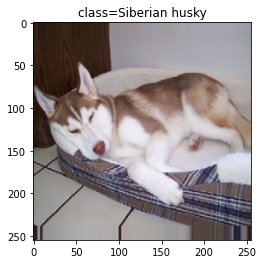

In [14]:
# 訓練データの表示
x_train, y_train = next(dataloader_ins.train_generator)
x_train, y_train = x_train[0], y_train[0]  # 1枚だけ画像を取得
i_label = y_train.argmax() # one-hotから答えのラベルを取得
ans = indeces_to_labels[i_label]

plt.imshow(x_train)
plt.title('class=' + ans)

In [15]:
x_train.shape

(255, 255, 3)

In [16]:
train_images_np = [x_train for _ in range(len(gt_boxes))]

# Annotate images with bounding boxes

In this cell you will annotate the rubber duckies --- draw a box around the rubber ducky in each image; click `next image` to go to the next image and `submit` when there are no more images.

If you'd like to skip the manual annotation step, we totally understand.  In this case, simply skip this cell and run the next cell instead, where we've prepopulated the groundtruth with pre-annotated bounding boxes.



# In case you didn't want to label...

Run this cell only if you didn't annotate anything above and
would prefer to just use our preannotated boxes.  Don't forget
to uncomment.

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [17]:

# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1
num_classes = 2

category_index = {duck_class_id: {'id': duck_class_id, 'name': 'rubber_ducky'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for i, (train_image_np, gt_box_np) in enumerate(zip(
    train_images_np, gt_boxes)):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  #zero_indexed_groundtruth_classes = tf.convert_to_tensor(
  #      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.zeros(shape=[gt_box_np.shape[0]], dtype=np.int32) + df_bbox_info.loc[i, 'class_index'])
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')


Done prepping data.


# Let's just visualize the rubber duckies as a sanity check


In [18]:
category_index

{1: {'id': 1, 'name': 'rubber_ducky'}}

In [19]:
indeces_to_labels

{0: 'Pomeranian', 1: 'Siberian husky'}

In [20]:
category_index = {0: {'id': 1, 'name': 'Pomeranian'}, 1: {'id': 2, 'name': 'Siberian husky'}}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


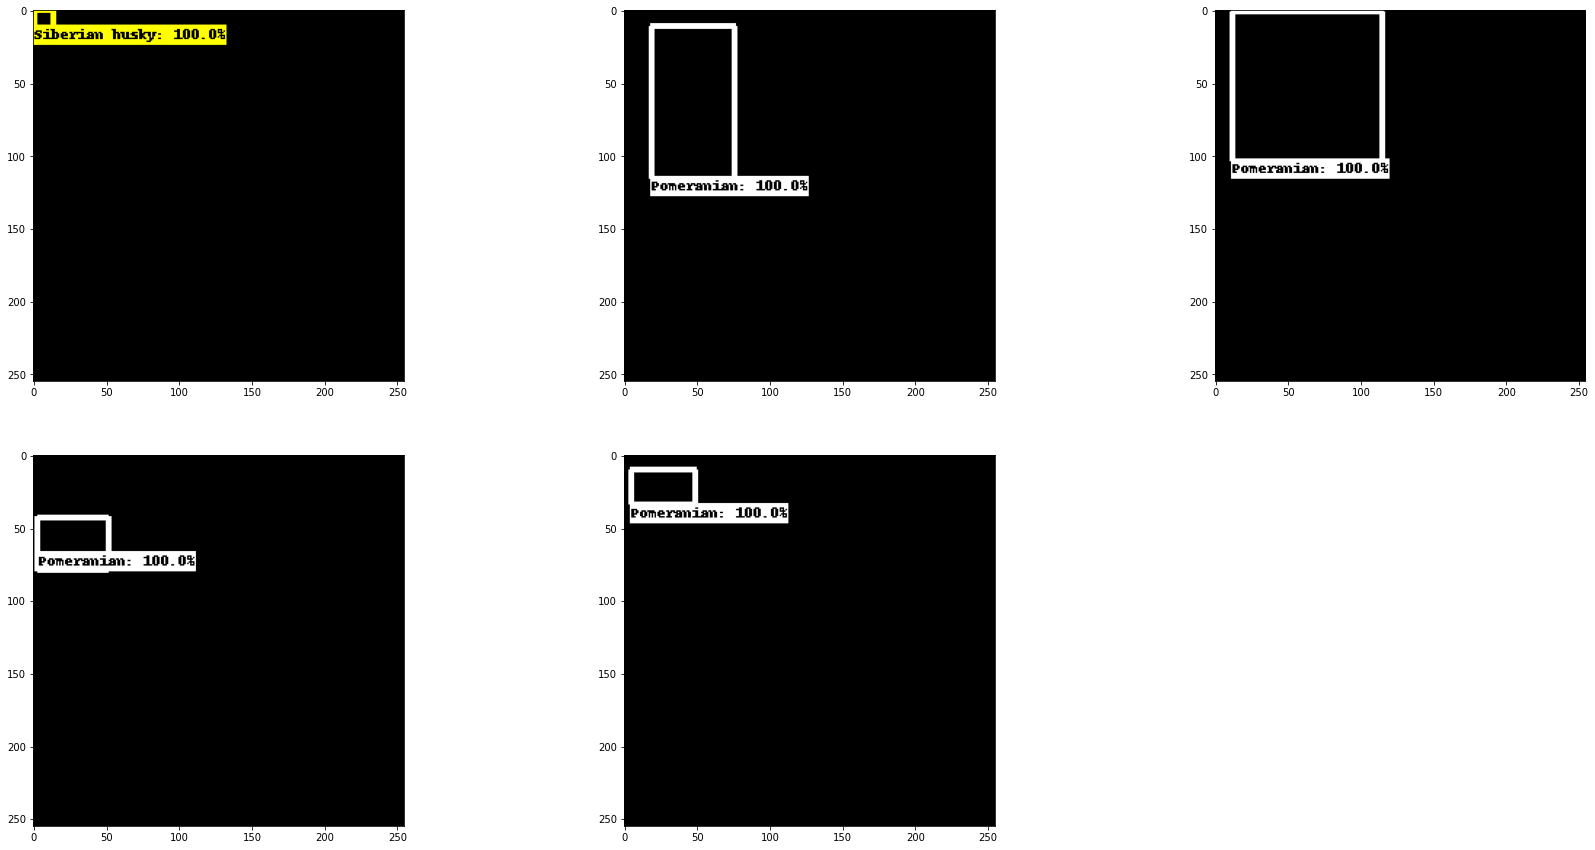

In [21]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2,3, idx+1)
  idx += 15
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.zeros(shape=[gt_boxes[idx].shape[0]], dtype=np.int32)+df_bbox_info.loc[idx, 'class_index'],
      dummy_scores, category_index)
plt.show()

# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [22]:
models_path

'/home/tensorflow/models'

In [23]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint object_detection/test_data/

--2020-10-17 03:27:19--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.161.48, 2404:6800:4004:809::2010
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.161.48|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  6.93MB/s    in 32s     

2020-10-17 03:27:52 (7.26 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.2’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'object_detection/test_data/checkpoint': Directory not empty


In [24]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 2
pipeline_config = models_path + '/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = models_path + '/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [25]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 4
learning_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 100, loss=2.3131814
batch 10 of 100, loss=1.0540497
batch 20 of 100, loss=2.2730477
batch 30 of 100, loss=1.9709905
batch 40 of 100, loss=1.2745146
batch 50 of 100, loss=1.1889162
batch 60 of 100, loss=1.749852
batch 70 of 100, loss=1.9057565
batch 80 of 100, loss=2.3592167
batch 90 of 100, loss=4.586762
Done fine-tuning!


# Load test images and run inference with new model!

In [ ]:
test_image_dir = models_path + '/research/object_detection/test_images/ducky/test/'
test_images_np = []
for i in range(1, 50):
  image_path = os.path.join(test_image_dir, 'out' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

In [ ]:
imageio.plugins.freeimage.download()

anim_file = 'duckies_test.gif'

filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []
for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=5)

display(IPyImage(open(anim_file, 'rb').read()))